In [1]:
from setup import *

# 1. Refitting activities using 80-channel and 96-channel signatures

As we discovered large amount of T>C mutations may be present in FFPE sequenced data from [study1 analysis](https://qingliguo.github.io/FFPEsig/FFPEsig_discovery.html) as well as un our [WGS FFPE data](https://qingliguo.github.io/FFPEsig/Correcting_FFPEnoise_in_WGS_FFPE_CRCs.html) with no unified noise profile, here we try to explore the impact of removing T>C mutations in FFPE samples during signature refitting analysis. We contrast the refiting results of using full 96-channel and also using 80-channel with T>C.

## 1.1 Loading data

Read signature activities for PCAWG mutational catalogues. Remove samples with reconstruction accuracy less than 0.85 based on original anlysis in PCAWG paper.

In [2]:
## Read signature activities of PCAWG catalogues
activity = pd.read_csv("./Data/WGS_PCAWG.activities.csv")
## Remove samples with reconstruction accuracy lower than 0.85
hc_ind = activity['Accuracy'].values > 0.85
activity_hc = activity.loc[hc_ind,:].copy()
print (activity.shape, activity_hc.shape)
activity_hc.head(1)

(2780, 68) (2745, 68)


,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0


Read 96-channel COSMIC V3 mutational signatures and generate 80-channel signatures

In [3]:
SBS_sig = pd.read_csv("./Data/SBS_signatures.csv")
SBS_sig_96c = SBS_sig.iloc[:, 2:].copy()

## Generate 80-channel signature
T2C_ind = SBS_sig.Type.values == "T>C"
non_T2C_ind = SBS_sig.Type != "T>C"
SBS_sig_80c_beforeNorm = SBS_sig_96c.loc[non_T2C_ind, :].copy()
SBS_sig_80c = SBS_sig_80c_beforeNorm.apply(lambda row: row / SBS_sig_80c_beforeNorm.sum(axis = 0), axis = 1)

SBS_sig_96c.shape, SBS_sig_80c.shape

((96, 65), (80, 65))

Read PCAWG mutational catalogues

In [4]:
profiles = pd.read_csv ("./Data/WGS_PCAWG.96.csv")
profiles_values = profiles.iloc[:,2:]
## remove samples with low reconstruction accuracy (0.85)
profiles_values_hc_96c = profiles_values.loc[:,hc_ind].copy()
## generate 80-channel profiles 
profiles_values_hc_80c = profiles_values_hc_96c.loc[non_T2C_ind,:].copy()

profiles_values_hc_96c.shape, profiles_values_hc_80c.shape

((96, 2745), (80, 2745))

## 1.2 Refitting activities

Refitting activities using 96c and 80c signatures for the same sample with and without T>C mutations.

In [5]:
## Collect information to form a master dataframe
act_sig, cancer_type, sample_id = [], [], []
pred_96c, acc_96c = [], []
pred_80c, pred_80c_rescaled, acc_80c= [], [], []

n = profiles_values_hc_96c.shape[1]

for i in range (n):  # refitting 96c and 80c signature activites for each sample

    active_sig_ind = activity_hc.iloc[i,3:] > 0 # select active signatures (>0) based on PCAWG activites data 
    active_sig_num = np.sum(active_sig_ind)    
    act_sig += list(SBS_sig_96c.columns[active_sig_ind])
    
    type_tmp, sample_tmp = (profiles_values_hc_96c.columns[i].split("::")) # Record cancer type and sample ID
    cancer_type += [type_tmp] * active_sig_num
    sample_id += [sample_tmp] * active_sig_num
    
    ## refit activities for sample i using 96-channel signature.
    ## To make the results comparable, we here use the same refitting model on both 96c and 80c signatures
    channel_num = 96
    npr.seed(i)
    
    h96, kl_loss = sig_refitting(V = profiles_values_hc_96c.iloc[:,i].to_numpy().reshape(channel_num, 1), 
                               W = SBS_sig_96c.loc[:, active_sig_ind].to_numpy(), precision = 0.99)
    pred_96c += list(np.round (h96.reshape(active_sig_num)))
    v_hat96 = np.round(SBS_sig_96c.loc[:,active_sig_ind] @ np.round (h96.reshape(active_sig_num)))
    acc_tmp96 = np.round(cosine_similarity(v_hat96.to_numpy().reshape(1, channel_num),
                                         profiles_values_hc_96c.iloc[:, i].to_numpy().reshape(1, channel_num))[0][0],3)
    acc_96c.append(acc_tmp96)
    
    ## refit activities for sample i using 80-channel signature.
    channel_num = 80 
    h80, kl_loss = sig_refitting(V = profiles_values_hc_80c.iloc[:, i].to_numpy().reshape(channel_num, 1), 
                               W = SBS_sig_80c.loc[:, active_sig_ind].to_numpy(), precision = 0.99)
    pred_tmp = np.round (h80.reshape(active_sig_num))
    pred_80c += list(pred_tmp)
    ## reproject the activities from 80-channel and make them comparable with those from 96-channel.
    ratios = np.array (1 - SBS_sig_96c.loc[T2C_ind, active_sig_ind].sum())
    rescaled_pred = np.round(pred_tmp / ratios)
    pred_80c_rescaled += list(rescaled_pred)
    
    v_hat80 = SBS_sig_80c.loc[:,active_sig_ind] @ rescaled_pred
    acc_tmp80 = np.round(cosine_similarity(v_hat80.to_numpy().reshape(1, channel_num),
                                         profiles_values_hc_80c.iloc[:, i].to_numpy().reshape(1, channel_num))[0][0],3)
    acc_80c.append(acc_tmp80)

In [6]:
## Build dataframe containing the reconstruction accuracy for each sample.
accuracy_df = pd.DataFrame({'Samples':profiles_values_hc_96c.columns.values,
             'accuracy_96c': acc_96c,
             'accuracy_80c': acc_80c})
accuracy_df.rename(columns={
    'Samples' : '#Samples'}).to_csv("./Data/Refitting_Accuracy_80c_96c.csv", 
                                    sep = "\t", index = False)

## Build dataframe containing the following columns:
df_activity = pd.DataFrame ({'Cancer_type': cancer_type, 
                             'Sample':sample_id, 
                             'Sig':act_sig,                             
                             '96c': pred_96c,
                             '80c': pred_80c,
                             '80c_ajusted': pred_80c_rescaled})

## Add Log10 ratio of ajusted 80channel activities/96-channel activities.
df_activity['LR(80c_adj/96c)'] = np.log10 ((df_activity['80c_ajusted'] + 1)/(df_activity['96c'] + 1))

## Write the dataframe to Data folder
df_activity.rename(columns={
    'Cancer_type' : '#Cancer_type'}).to_csv("./Data/Refitting_Activities_Results_80c_96c.csv",
                                            sep = "\t", index = False)

df_activity.head(2)

,Cancer_type,Sample,Sig,96c,80c,80c_ajusted,LR(80c_adj/96c)
0,Biliary-AdenoCA,SP117655,SBS1,1471.0,1271.0,1304.0,-0.052297
1,Biliary-AdenoCA,SP117655,SBS2,1359.0,1291.0,1292.0,-0.021940


## 1.3 Defining inconsistecy rate

In [7]:
df_activity = pd.read_csv ("./Data/Refitting_Activities_Results_80c_96c.csv", sep = "\t")
df_activity = df_activity.rename(columns={'#Cancer_type': 'Cancer_type'})
df_activity.head(2)

,Cancer_type,Sample,Sig,96c,80c,80c_ajusted,LR(80c_adj/96c)
0,Biliary-AdenoCA,SP117655,SBS1,1471.0,1271.0,1304.0,-0.052297
1,Biliary-AdenoCA,SP117655,SBS2,1359.0,1291.0,1292.0,-0.021940


+ Group the dataframe using cancer type and signature info. Filter out groups with samples number less than 10.
+ Check how many samples filtered out

In [8]:
num = 10
df_activity.columns.values[0] = "Cancer_type"
passed_filter = df_activity.groupby(['Cancer_type', 
                                     'Sig']).count()[df_activity.groupby(['Cancer_type', 
                                                                          'Sig']).count()['96c'] > num]
passed_pairs = passed_filter.index.values
passed_ind = [i in list(passed_pairs) for i in zip(df_activity.Cancer_type, df_activity.Sig)]

activity_contrast_final = df_activity.loc[passed_ind,:].copy()

## samples excluded from the filter
first = profiles_values.shape[1] - profiles_values_hc_96c.shape[1]
second = len (df_activity.Sample.unique())-len(activity_contrast_final.Sample.unique())

{'filtered_due_to_low_accuracy': first, 
 "filtered_due_to_low_sample_size": second, 
 "total filtered": first + second}

{'filtered_due_to_low_accuracy': 35,
 'filtered_due_to_low_sample_size': 19,
 'total filtered': 54}

**Here we use inconsistency rate to measure how well the refitting results from two sets of signatures agree with each other**
```
Inconsistency rate = log10 (activity_80c/activity_96c)
```

## 1.4 Relationship of inconsistency rate versus T>C mutation rate of signatures 

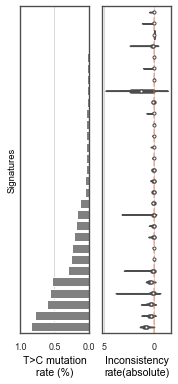

In [9]:
T2C_perc_df = pd.DataFrame()
all_sigs = activity_contrast_final['Sig'].unique() 
T2C_perc_df['Sig'] = [i for i in all_sigs]

T2C_perc = SBS_sig_96c.iloc[T2C_ind,:].sum()
T2C_perc_df['T2C_Perc'] = [T2C_perc[i] for i in all_sigs]

T2C_perc_df_sorted = T2C_perc_df.sort_values(by = "T2C_Perc")
all_sigs_sorted_by_T2Cperc = T2C_perc_df_sorted.Sig.values

sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1.35,})

f, (ax1, ax2) = plt.subplots(1,2, figsize = (2.7,6), sharey = True)

sns.barplot(data = T2C_perc_df_sorted, y = "Sig", x = "T2C_Perc", color = "grey", ax = ax1)
ax1.set_yticks([])
ax1.set_ylabel('')

ax1.set_xlabel("T>C mutation\nrate (%)", size = 10.5, color = "black")
ax1.set_xlim (0,1)
ax1.invert_xaxis()
ax1.set_ylabel('Signatures', color = "black", size = 9.5)
ax1.tick_params(axis='both', which='major', labelsize=9, color = "black")


sns.violinplot(x = np.absolute(activity_contrast_final ["LR(80c_adj/96c)"]), y="Sig", 
               data=activity_contrast_final, color = "grey",
               order=all_sigs_sorted_by_T2Cperc, ax = ax2)

ax2.axvline(0, linestyle = "--", color = "tomato", alpha = 0.5)
ax2.set_yticks([])
#ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlabel("Inconsistency\nrate(absolute)",size = 10.5, color = "black")
ax2.tick_params(axis='both', which='major', labelsize=9, color = "black")
ax2.invert_xaxis()
plt.savefig("./Figures/Fig5a_1.pdf", bbox_inches = "tight", dpi = 300)

plt.show()

Signatures with high inconsistency rate

In [10]:
values = activity_contrast_final.groupby(by = "Sig")["LR(80c_adj/96c)"].mean()
values[(values > np.log10(1.5)).values + (values < np.log10(0.5)).values]

Sig
SBS12     0.851729
SBS16     0.361228
SBS17a    0.365469
SBS6     -1.344148
SBS7d     0.327630
Name: LR(80c_adj/96c), dtype: float64

slope: 0.5789884335955218 	Intercept: 0.0270075555001089
Spearmans correlation: 0.5377143207673556 	pvalue: 0.0


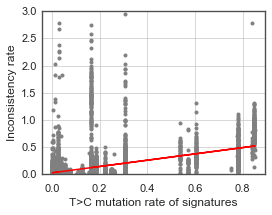

In [11]:
f, ax = plt.subplots( figsize = (4,3))

x = np.array([T2C_perc[s] for s in df_activity.Sig])
y = np.absolute(df_activity['LR(80c_adj/96c)'])

m, b = np.polyfit(x, y, 1)
print ("slope:",m, "\tIntercept:",b)

corr, _ = spearmanr(x, y)
print ("Spearmans correlation:", corr,"\tpvalue:",  _)

## scatter plot of x and y
ax.plot(x, y, 'o', markersize = 3, color = "grey")
ax.set_ylim (0,3)

#add linear regression line to scatterplot 
ax.plot(x, m * x + b, color = 'red')
ax.set_xlabel ("T>C mutation rate of signatures")
ax.set_ylabel ("Inconsistency rate")
plt.show()

## 1.5 Overall refitting comparison results

We next checked the results for each signature from per cancer type.

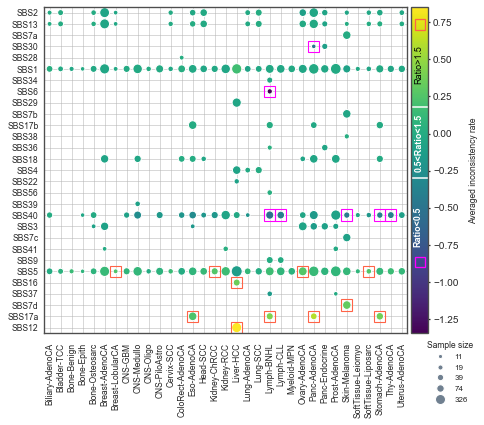

In [12]:
df_mean = activity_contrast_final.groupby(['Cancer_type', 'Sig']).mean()['LR(80c_adj/96c)']
dict_mean = df_mean.to_dict() ## mean of log10 ratios of activities

df_logcount = np.log(activity_contrast_final.groupby(['Cancer_type', 'Sig']).count()['LR(80c_adj/96c)'])
dict_logcount = df_logcount.to_dict() ##  log of sample size 

## xlabel: Cancer
N = len(activity_contrast_final.Cancer_type.unique())
xlabels = activity_contrast_final.Cancer_type.unique()
## ylabel: sigs
M = len(activity_contrast_final.Sig.unique())
ylabels = all_sigs_sorted_by_T2Cperc[::-1]

## collecting data for circle plot
s = np.zeros(shape=(N,M)) ## sample size -> cycle size
c = np.zeros(shape=(N,M)) ## mean
for i, cancer in enumerate(xlabels):
    for j, sig in enumerate(ylabels):
        c[i,j] = dict_mean.get((cancer, sig), 0)
        s[i,j] = dict_logcount.get((cancer, sig), 0)
        
fig, ax = plt.subplots(figsize=(7, 6))
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1.35,})

## ploting circles for each group. Color is using mean of log ratio. Size is using sample size.
x, y = np.meshgrid(np.arange(M), np.arange(N))
R = s/s.max()/2
circles = [plt.Circle((j,i), radius=r) for r, i, j in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array = c.flatten(), cmap = 'viridis') #viridis
ax.add_collection(col)

## mark rectangle on groups which is over upperlimit or less than lowerlimit
upperlimit, lowerlimit = np.log10(1.5), np.log10(0.5)
for i in range (N):
    for j in range(M):
        if c[i, j] > upperlimit:
            rect = patches.Rectangle((i - 0.5, j - 0.5) , 1, 1, 
                                     linewidth = 1.1, edgecolor = 'tomato', facecolor = 'none')
            ax.add_patch(rect)
            
        if c[i, j] < lowerlimit:
            rect = patches.Rectangle((i - 0.5,j - 0.5), 1, 1 ,
                                     linewidth = 1.1, edgecolor = 'fuchsia', facecolor = 'none')
            ax.add_patch(rect)

## color bar of the heatmap plot
cbar = fig.colorbar(col, fraction = 0.06, pad = 0.01)
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel('Averaged inconsistency rate', rotation = 90, size = 8.5)
cbar.ax.tick_params(axis="y", labelsize=10)
cbar.ax.plot([-1.5, 1.5], [upperlimit, upperlimit], 'w')
cbar.ax.plot([-1.5, 1.5], [lowerlimit, lowerlimit], 'w')

cbar.ax.annotate('Ratio>1.5', xy=(-0.9, upperlimit + 0.17), color = "black", rotation = 90, size = 9)
rect = patches.Rectangle((-0.8, 0.7) , 1.3, 0.07, 
                        linewidth = 1.3, edgecolor = 'tomato', facecolor = 'none')
cbar.ax.add_patch(rect)
cbar.ax.annotate('0.5<Ratio<1.5', xy=(-0.9, upperlimit - 0.42), color = "white", 
                 weight = "bold", rotation = 90, size = 9)
cbar.ax.annotate('Ratio<0.5', xy=(-1, lowerlimit - 0.45), color = "white", rotation = 90, size = 9,
                weight = "bold")

rect = patches.Rectangle((-0.8, - 0.9) , 1.3, 0.07, 
                        linewidth = 1.3, edgecolor = 'fuchsia', facecolor = 'none')
cbar.ax.add_patch(rect)

## sample size legend

tag_circle_size = np.quantile (df_logcount.values, np.array([0, 0.25, 0.5, 0.75, 1]))
tag_values = np.exp(np.quantile (df_logcount.values, np.array([0, 0.25, 0.5, 0.75, 1])))
norm_tag_circle_size = tag_circle_size /tag_circle_size [-1]

c1,c2,c3,c4,c5 = [Line2D(range(1), range(1), color="white", marker='o',markersize= 10 * norm_tag_circle_size[i],
                         markerfacecolor="slategray") for i in range(len(norm_tag_circle_size))]
legend = plt.legend((c1,c2,c3,c4,c5),
                    np.around(tag_values).astype("int32"),
                    scatterpoints=1,
                    bbox_to_anchor=(1.2, 0),
                    frameon = False,
                    ncol = 1,fontsize = 8,
                    title = 'Sample size')

legend.get_title().set_fontsize('8.5')

## axis setting
ax.set(xticks = np.arange(N), yticks = np.arange(M),
       xticklabels = xlabels, yticklabels = ylabels)

ax.set_xticks(np.arange(N + 1) - 0.5, minor = True)
ax.set_yticks(np.arange(M + 1) - 0.5, minor = True)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')

plt.xticks(rotation = 90, size = 8.5)
plt.yticks(size = 8.5)
plt.savefig("./Figures/Fig5a_2.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 1.6 Comparing refitted mutation count for each signture

Here is a direct comparison of refitted actcities using two sets of signatures.

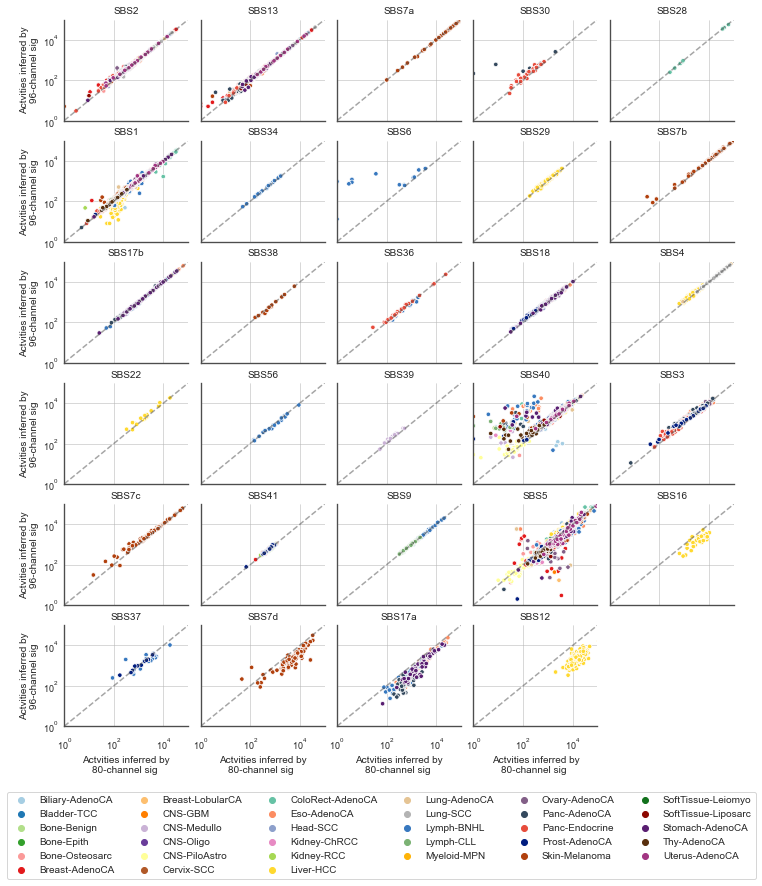

In [13]:
cancer_colors = (sns.color_palette("Paired", 12) + sns.color_palette("Set2") + 
            sns.xkcd_palette(["windows blue", "faded green","amber","dusty purple"]) + 
                             sns.color_palette(["#34495e","#e74c3c"]) + sns.color_palette("dark",7))
color_dict = {}
all_cancers = activity_contrast_final.Cancer_type.unique()
for i,cancer in enumerate(all_cancers):
    color_dict [cancer] = cancer_colors[i]
    
## to get handels and lables, will not plot here
f, ax = plt.subplots()
ax = sns.scatterplot(x="80c_ajusted", y="96c", hue="Cancer_type", 
                data = activity_contrast_final, edgecolor= 'white', palette= color_dict, s = 30)
handles, labels = ax.get_legend_handles_labels()
plt.close()

fig_ind = []
nrow = 6
ncol = 5
for i in range(nrow):
    for j in range(ncol):
        fig_ind.append((i,j))
        
sf6, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, gridspec_kw={ 'wspace': 0.1},figsize=(12, 13))
n = 0
for i,sig in enumerate(all_sigs_sorted_by_T2Cperc):
    axs[fig_ind[n]].set(xscale="log", yscale="log")
    df_tmp = activity_contrast_final.loc[activity_contrast_final.Sig == sig, :].copy()
    sns.scatterplot(x="80c_ajusted", y="96c", hue="Cancer_type", data=df_tmp, 
                    ax =axs[fig_ind[n]], edgecolor= 'white', palette= color_dict, s = 20)
    sns.despine()
    axs[fig_ind[n]].plot([0, 1], [0, 1], transform=axs[fig_ind[n]].transAxes, ls="--", c=".3", alpha = 0.5)
    axs[fig_ind[n]].set_xlim(1,100000)
    axs[fig_ind[n]].set_ylim(1,100000)
    axs[fig_ind[n]].xaxis.set_tick_params(labelsize=9)
    axs[fig_ind[n]].yaxis.set_tick_params(labelsize=9)
    axs[fig_ind[n]].set_xlabel ("Actvities inferred by\n80-channel sig ", size = 10)
    axs[fig_ind[n]].set_ylabel ("Actvities inferred by\n96-channel sig",  size = 10)
    axs[fig_ind[n]].set_title (sig, size = 10)
    axs[fig_ind[n]].legend('',frameon=False)
    n = n+1 

sf6.delaxes(axs[(nrow-1, ncol-1)])
plt.legend( handles [1:], labels[1:], bbox_to_anchor=(-3.8,-0.6), 
           loc=2, borderaxespad=0.5, frameon = True, ncol=6, fontsize= 10)
plt.savefig("./Figures/SFig16.pdf")
plt.show()

## 1.7 Activities flow between similar sigtures

The high inconsistent results are not only showing in high T>C mutation rate signatures but also in SBS5/40. So we will check if the inconsistency is caused by high similarity of the two signatures

In [14]:
sbs5_sbs40_ind = (activity_hc['SBS5']>0).to_numpy() * (activity_hc['SBS40']>0).to_numpy()
both_positive_sample_ids = activity_hc.loc [sbs5_sbs40_ind,:]['Sample Names'].to_numpy()

## get those samples out from final dataframe. Change the dataframe from long type to wide type:
both_positive_ind = [i in both_positive_sample_ids for i in df_activity.Sample ]
df_activity_SBS5_SBS40_coexist = df_activity.loc[both_positive_ind, :]
df_activity_SBS5 = df_activity_SBS5_SBS40_coexist.loc[(df_activity_SBS5_SBS40_coexist.Sig == "SBS5").to_numpy(),:]
df_activity_SBS40 = df_activity_SBS5_SBS40_coexist.loc[(df_activity_SBS5_SBS40_coexist.Sig == "SBS40").to_numpy(),:]

df_activity_SBS5_SBS40_wt = df_activity_SBS5.merge(df_activity_SBS40, on = "Sample", suffixes = ("_SBS5","_SBS40"))
df_activity_SBS5_SBS40_wt = df_activity_SBS5_SBS40_wt.drop(['Sig_SBS5', 'Cancer_type_SBS40','Sig_SBS40'], axis = 1)
df_activity_SBS5_SBS40_wt = df_activity_SBS5_SBS40_wt.rename (columns = {'Cancer_type_SBS5' : 'Cancer_type'})

df_activity_SBS5_SBS40_wt['SBS5_SBS40_96c_sum'] = df_activity_SBS5_SBS40_wt[['96c_SBS5',
                                                                             '96c_SBS40']].sum(axis = 1)
df_activity_SBS5_SBS40_wt['SBS5_SBS40_80c_sum'] = df_activity_SBS5_SBS40_wt[['80c_ajusted_SBS5',
                                                                             '80c_ajusted_SBS40']].sum(axis = 1)
df_activity_SBS5_SBS40_wt.head(2)

,Cancer_type,Sample,96c_SBS5,80c_SBS5,80c_ajusted_SBS5,LR(80c_adj/96c)_SBS5,96c_SBS40,80c_SBS40,80c_ajusted_SBS40,LR(80c_adj/96c)_SBS40,SBS5_SBS40_96c_sum,SBS5_SBS40_80c_sum
0,Biliary-AdenoCA,SP117655,2670.0,4119.0,5928.0,0.346308,8661.0,5578.0,6667.0,-0.113623,11331.0,12595.0
1,Biliary-AdenoCA,SP117556,4112.0,1249.0,1798.0,-0.359128,123.0,2110.0,2522.0,1.308496,4235.0,4320.0


Spearmans correlation: -0.6872829381572466 	pvalue: 6.221393619903708e-164


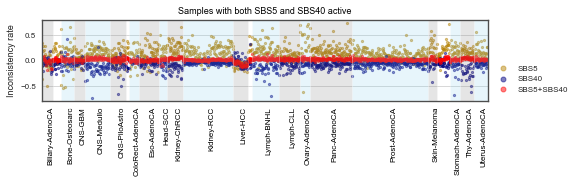

In [15]:
corr, _ = spearmanr(df_activity_SBS5_SBS40_wt['LR(80c_adj/96c)_SBS5'], 
                   df_activity_SBS5_SBS40_wt['LR(80c_adj/96c)_SBS40'])
print ("Spearmans correlation:", corr,"\tpvalue:",  _)

f, ax = plt.subplots(figsize=(8, 1.5))
style = dict(size = 8, color='black')
ax.margins(x=0.001, y=0.001)

all_cancer_types = list(df_activity_SBS5_SBS40_wt['Cancer_type'])
uq_cancer_type = list(df_activity_SBS5_SBS40_wt['Cancer_type'].unique())
sample_sizes = [all_cancer_types.count(i) for i in uq_cancer_type]

previous = 'skyblue'
for i, size in enumerate(sample_sizes):
    if size >=20:
        previous_sample_size = sum(sample_sizes[:i])
        
        if previous == 'skyblue':
            plt.axvspan(previous_sample_size, previous_sample_size + size, facecolor='grey', alpha=0.2)
            previous = "grey"
        elif previous == "grey":
            plt.axvspan(previous_sample_size, previous_sample_size + size, facecolor='skyblue', alpha=0.2)
            previous = "skyblue"
            
        ax.text(previous_sample_size + size/2, -0.9, uq_cancer_type[i], verticalalignment='top',
                **style, rotation = 90)
n = df_activity_SBS5_SBS40_wt.shape[0]
ax.scatter (range(n), df_activity_SBS5_SBS40_wt['LR(80c_adj/96c)_SBS5'], 
             alpha = .5,s = 5,color = "darkgoldenrod", label = "SBS5")
ax.scatter (range(n), df_activity_SBS5_SBS40_wt['LR(80c_adj/96c)_SBS40'],
             alpha = .5, s = 5,color = "navy" , label = "SBS40")
ax.scatter (range(n), 
             np.log10(df_activity_SBS5_SBS40_wt['SBS5_SBS40_80c_sum']/df_activity_SBS5_SBS40_wt['SBS5_SBS40_96c_sum']), 
             s = 5, color = "red", alpha = 0.5, label = "SBS5+SBS40")

ax.set_ylim (-0.8,0.8)
ax.margins(x = 0.001, y=0.001)
ax.legend(bbox_to_anchor=(1, 0.54), markerscale = 2.2, fontsize = 8, frameon = False)
ax.set_title("Samples with both SBS5 and SBS40 active", size = 9, color = "black")
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel ("Inconsistency rate", size = 9)
plt.yticks(size = 8)
plt.savefig("./Figures/Fig5b.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

# 2. The similarity changes of signature pairs due to T>C removal

As similairty has a big impact on attribution refitting, we finnally explored how much of the sample-pair similarity changes by using 80c-sig compared to 96-c signature for all SBS signatures.

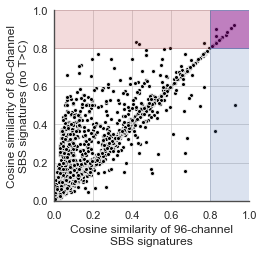

In [16]:
whole_sim = cosine_similarity(SBS_sig_96c.T, SBS_sig_96c.T)
whole_sim_tri = list(whole_sim[np.triu_indices(len(whole_sim), k = 1)])

removed_sim = cosine_similarity(SBS_sig_80c.T, SBS_sig_80c.T)
removed_sim_tri = list(removed_sim[np.triu_indices(len(removed_sim), k = 1)])

f, ax = plt.subplots(figsize=(3.5, 3.5))
ax = sns.scatterplot(whole_sim_tri, removed_sim_tri, s = 15, color = "black")

rect = patches.Rectangle((0,0.8),0.8,0.2,linewidth=1, edgecolor='r',facecolor='r', alpha = 0.2)
ax.add_patch(rect)
rect = patches.Rectangle((0.8,0),0.2,0.8,linewidth=1, edgecolor='b',facecolor='b', alpha = 0.2)
ax.add_patch(rect)
rect = patches.Rectangle((0.8,0.8),0.2,0.2,linewidth=1, edgecolor='b',facecolor='purple', alpha = 0.5)
ax.add_patch(rect)
plt.xlim (0,1)
plt.ylim (0,1)
sns.despine()
plt.xlabel ("Cosine similarity of 96-channel\nSBS signatures")
plt.ylabel ("Cosine similarity of 80-channel\nSBS signatures (no T>C)")
plt.savefig("./Figures/SFig17b.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

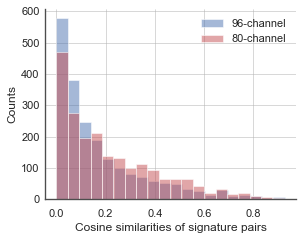

In [17]:
f, ax = plt.subplots(figsize=(4.5, 3.5))
plt.hist(whole_sim_tri, bins = 20, alpha = 0.5, label = "96-channel", color = "b", edgecolor= 'white')
plt.hist(removed_sim_tri, bins = 20, alpha = 0.5, label = "80-channel", color = "r", edgecolor= 'white')
plt.legend(frameon = False)
sns.despine()
plt.xlabel("Cosine similarities of signature pairs")
plt.ylabel("Counts")
plt.savefig("./Figures/SFig17a.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

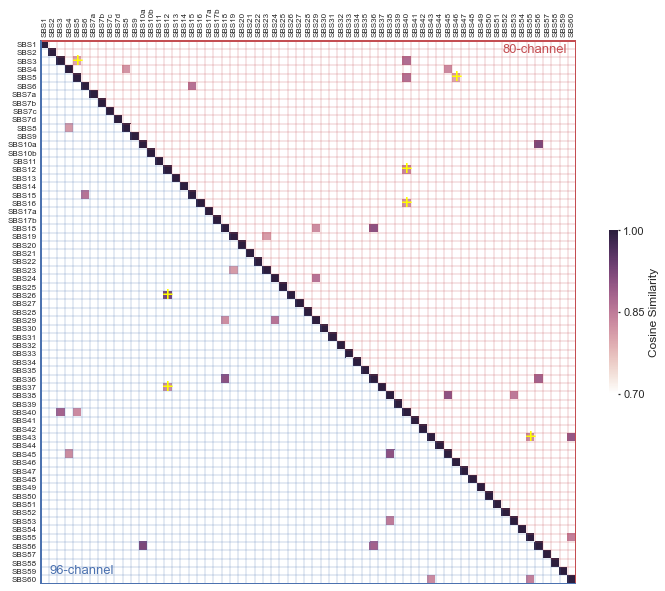

In [18]:
f = plt.figure(figsize=(12,10))

whole_sim_copy = whole_sim.copy()
whole_sim_copy[whole_sim < 0.8] = 0 ## remove the low similarity values for 96c

removed_sim_copy = removed_sim.copy()
removed_sim_copy[removed_sim < 0.8] = 0  ## remove the low similarity values for 80c

## Merge data
whole_sim_copy[np.triu_indices(len(whole_sim_copy), 
                               k = 1)] =removed_sim_copy[np.triu_indices(len(removed_sim_copy), k = 1)]

## heatmap plot
labels = ['SBS' + i.split('BS')[1] for i in SBS_sig_96c.columns]
ax = sns.heatmap(whole_sim_copy,cmap = sns.cubehelix_palette(light = 1, as_cmap = True),
                 vmin=0.7, vmax=1, xticklabels = labels, yticklabels = labels, 
                 cbar_kws = {'shrink': .3, 'ticks' : np.linspace(0.7, 1,3), 'label': f"Cosine Similarity"})

ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(labels, rotation = 90, fontsize = 8)
ax.set_yticklabels(labels, fontsize = 8)
ax.tick_params(direction='out', length=6, width=2, grid_color='r', size=0, grid_alpha=0.3)

## color the grids in each section
for i in range (1,65):
    line_alpha = 0.2
    ## for 80c
    ax.hlines([i],i,65, alpha = line_alpha, color = "r")
    ax.vlines([i],i,0, alpha = line_alpha, color = "r")
    ## 96c
    ax.hlines([i],0,i,alpha = line_alpha, color = "b")
    ax.vlines([i],i,65, alpha = line_alpha, color = "b")

## highlight the pairs with similarity over 0.5.
for i in range (65):
    for j in range(65):
        if whole_sim_copy[i,j] > 0.8 and whole_sim_copy[j,i] == 0 and j > i:
            ax.text( j+0.5, i+0.5,'+', color='yellow', size=20, ha='center', va='center')
        
        if whole_sim_copy[i,j] > 0.8 and whole_sim_copy[j,i] == 0 and j < i:
            ax.text( j+0.5 , i+0.5, '+', color='yellow', size=20, ha='center', va='center')
            
## Edges and annotation
ax.hlines(0, *ax.get_xlim(),  lw = 3, color = "r", )
ax.vlines(65, *ax.get_xlim(), lw = 3, color = "r", )
ax.text(60, 1.2 , "80-channel",size = 13, color = "r", 
                horizontalalignment='center',verticalalignment='center')

ax.vlines(0, *ax.get_xlim(),  lw = 3, color = "b", )
ax.hlines(65, *ax.get_xlim(), lw = 3, color = "b", )
ax.text(5, 63.5 , "96-channel",size = 13, color = "b", 
                horizontalalignment='center',verticalalignment='center')
plt.savefig("./Figures/SFig17c.pdf", bbox_inches = "tight", dpi = 300)
plt.show()